In [1]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingRegressor,AdaBoostRegressor,ExtraTreesRegressor
from IPython.display import display

from matplotlib import pyplot as plt
import re

import seaborn as sns

from scipy.stats import boxcox

from sklearn.metrics import mean_squared_error,roc_auc_score

def error(y_pred,y_true):
    return 1-np.sqrt(mean_squared_error(y_true,y_pred))

from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_val_predict

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import string

from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,LabelEncoder,OneHotEncoder

from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import lightgbm as lgb

from xgboost import XGBRegressor,XGBClassifier,XGBRFClassifier

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize,word_tokenize

from sklearn.decomposition import TruncatedSVD

import rfpimp as rf



def display_all(df):
    with pd.option_context("display.max_rows", 7000, "display.max_columns", 7000): 
        display(df)


In [2]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize']=[20,12]

In [5]:
def metric_rf(model,X_valid,y_valid,sample_weights=0):
    return roc_auc_score(model.predict(X_valid),y_valid)

In [6]:
def print_score(m):
    score={'roc_test':roc_auc_score(m.predict(X_test),y_test),
           'roc_train':roc_auc_score(m.predict(X_train),y_train),
           'r2_train':m.score(X_train,y_train),
           'r2_test':m.score(X_test,y_test)}
    if hasattr(m,'oob_score_'):
           score['oob_score']=m.oob_score_
    return score
        

In [7]:
def imp_cols_print_score(m):
    return {'roc_test':roc_auc_score(m.predict(X_test[important_cols]),y_test),
           'roc_train':roc_auc_score(m.predict(X_train[important_cols]),y_train),
           'r2_train':m.score(X_train[important_cols],y_train),
           'r2_test':m.score(X_test[important_cols],y_test),
           'oob_score':m.oob_score_}

In [8]:
def xx_print_score(m):
    return {'roc_test':roc_auc_score(m.predict(xxtest),y_test),
           'roc_train':roc_auc_score(m.predict(xxtrain),y_train),
           'r2_train':m.score(xxtrain,y_train),
           'r2_test':m.score(xxtest,y_test),
           'oob_score':m.oob_score_}

In [9]:
df=pd.read_csv('Cross Sell/Cross Sell.csv')

In [10]:
df.head()

,AcctAge,DDA,DDABal,CashBk,Checks,DirDep,NSF,NSFAmt,Phone,Teller,...,CRScore,Moved,InArea,Ins,Branch,Res,Dep,DepAmt,Inv,InvBal
0,0.3,1.0,419.27,0.0,0.0,0.0,0.0,0.0,0,0.0,...,696,0.0,1.0,1.0,B17,R,2.0,1170.06,0,0
1,0.7,1.0,1986.81,0.0,1.0,1.0,0.0,0.0,0,0.0,...,674,0.0,1.0,0.0,B2,R,1.0,446.93,0,0
2,4.1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0.0,...,640,0.0,1.0,1.0,B3,S,0.0,0.00,0,0
3,0.5,1.0,1594.84,0.0,1.0,0.0,0.0,0.0,0,1.0,...,672,0.0,1.0,0.0,B1,S,1.0,1144.24,0,0
4,6.7,1.0,2813.45,0.0,2.0,0.0,0.0,0.0,0,5.0,...,648,0.0,1.0,1.0,B1,S,2.0,1208.94,0,0


In [11]:
display_all(df.describe())

,DDA,DDABal,CashBk,Checks,DirDep,NSF,NSFAmt,Teller,Sav,SavBal,ATM,ATMAmt,CD,CDBal,IRA,IRABal,LOC,LOCBal,ILS,ILSBal,MM,MMBal,MMCred,MTG,MTGBal,SDB,Moved,InArea,Ins,Dep,DepAmt
count,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,3.226400e+04,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,3.226400e+04,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000
mean,0.815646,2170.016712,0.015962,4.259918,0.295562,0.087063,2.290546,1.365268,0.466898,3170.603687,0.609937,1235.414658,0.125837,2.530709e+03,0.053279,617.570455,0.063383,1175.219354,0.049591,517.569234,0.114896,1875.763193,0.056379,0.049343,8.081736e+03,0.108666,0.029631,0.960296,0.346361,2.134608,2232.760183
std,0.387779,7282.726998,0.131368,5.156643,0.456302,0.281932,14.363677,2.283765,0.498911,13397.146902,0.487772,4462.281901,0.331671,1.481178e+04,0.224593,7516.564820,0.243655,9605.284463,0.217102,2285.187054,0.318901,5484.479566,0.287484,0.216586,7.979412e+04,0.311225,0.169568,0.195265,0.475817,1.721797,6704.292297
min,0.000000,-774.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-613.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,59.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,149.650000
50%,1.000000,571.820000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,136.275000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,2.000000,1103.620000
75%,1.000000,1834.232500,0.000000,7.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1215.815000,1.000000,1202.797500,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,3.000000,2439.530000
max,1.000000,278093.830000,4.000000,49.000000,1.000000,1.000000,666.850000,27.000000,1.000000,700026.940000,1.000000,427731.260000,1.000000,1.053900e+06,1.000000,596497.600000,1.000000,523147.240000,1.000000,29162.790000,1.000000,120801.110000,5.000000,1.000000,1.088757e+07,1.000000,1.000000,1.000000,1.000000,28.000000,484893.670000


In [12]:
df.isnull().sum()/df.shape[0]

AcctAge    0.000031
DDA        0.000031
DDABal     0.000031
CashBk     0.000031
Checks     0.000031
DirDep     0.000031
NSF        0.000031
NSFAmt     0.000031
Phone      0.000031
Teller     0.000031
Sav        0.000031
SavBal     0.000031
ATM        0.000031
ATMAmt     0.000031
POS        0.000031
POSAmt     0.000031
CD         0.000031
CDBal      0.000031
IRA        0.000031
IRABal     0.000031
LOC        0.000031
LOCBal     0.000031
ILS        0.000031
ILSBal     0.000031
MM         0.000031
MMBal      0.000031
MMCred     0.000031
MTG        0.000031
MTGBal     0.000031
CC         0.000031
CCBal      0.000031
CCPurc     0.000031
SDB        0.000031
Income     0.000031
HMOwn      0.000031
LORes      0.000031
HMVal      0.000031
Age        0.000031
CRScore    0.000031
Moved      0.000031
InArea     0.000031
Ins        0.000031
Branch     0.000031
Res        0.000031
Dep        0.000031
DepAmt     0.000031
Inv        0.000031
InvBal     0.000031
dtype: float64

In [13]:
df.drop(32264,inplace=True)

In [14]:
test_percent=.8
split_test=int(test_percent*df.shape[0])
train=df[:split_test]
test=df[split_test:]

In [15]:
train.shape

(25811, 48)

In [16]:
test.shape

(6453, 48)

In [17]:
m=RandomForestClassifier()

m.fit(train.drop('Ins',axis=1),train[['Ins']])

In [19]:
display_all(df.tail(10))

,AcctAge,DDA,DDABal,CashBk,Checks,DirDep,NSF,NSFAmt,Phone,Teller,Sav,SavBal,ATM,ATMAmt,POS,POSAmt,CD,CDBal,IRA,IRABal,LOC,LOCBal,ILS,ILSBal,MM,MMBal,MMCred,MTG,MTGBal,CC,CCBal,CCPurc,SDB,Income,HMOwn,LORes,HMVal,Age,CRScore,Moved,InArea,Ins,Branch,Res,Dep,DepAmt,Inv,InvBal
32254,3.7,1.0,16.38,0.0,3.0,1.0,1.0,14.9,17,3.0,1.0,5.10,1.0,388.76,2,97.2,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0,0,0,0.0,31,1,7.5,102,25,640,0.0,1.0,0.0,B2,S,4.0,952.02,0,0
32255,8.6,1.0,46593.63,0.0,9.0,1.0,0.0,0.0,0,11.0,0.0,0.00,0.0,0.00,0,0,0.0,0.0,0.0,0.0,1.0,112306.85,0.0,0.00,1.0,47406.48,0.0,0.0,0.0,1,108200.42,0,0.0,45,1,8.5,207,70,721,0.0,1.0,0.0,B3,U,3.0,55203.58,0,0
32256,13,1.0,4062.53,0.0,16.0,0.0,0.0,0.0,0,8.0,1.0,5602.76,0.0,0.00,0,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,1.0,17094.72,0.0,0.0,0.0,0,0,0,0.0,41,1,8,107,69,698,0.0,1.0,0.0,B1,S,3.0,7383.58,0,0
32257,3.9,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.00,0.0,0.00,0,0,0.0,0.0,0.0,0.0,1.0,0.00,1.0,9912.78,0.0,0.00,0.0,0.0,0.0,1,178531.73,0,0.0,60,1,7,114,61,716,0.0,1.0,0.0,B2,S,0.0,0.00,0,0
32258,2.2,1.0,1037.98,0.0,2.0,1.0,0.0,0.0,0,0.0,1.0,44.67,1.0,72.64,0,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0,0,0,0.0,12,0,5.5,95,55,760,0.0,1.0,0.0,B4,R,1.0,679.43,0,0
32259,0.6,1.0,1073.88,0.0,8.0,1.0,0.0,0.0,0,0.0,0.0,0.00,1.0,307.49,0,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0,0,0,0.0,52,0,5,129,37,634,0.0,1.0,0.0,B16,R,2.0,978.54,0,0
32260,.,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.00,0.0,0.00,0,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,1,0,0,0.0,69,1,6.5,124,37,586,0.0,1.0,1.0,B1,S,0.0,0.00,0,0
32261,19.1,1.0,2139.59,0.0,7.0,1.0,0.0,0.0,2,0.0,0.0,0.00,1.0,1346.41,0,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0,0,0,0.0,.,.,.,.,.,596,0.0,1.0,1.0,B2,S,3.0,3226.87,0,0
32262,2.1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,4252.13,0.0,0.00,0,0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0,0,0,0.0,42,0,7.5,118,32,680,0.0,1.0,1.0,B5,S,0.0,0.00,0,0
32263,13,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.00,0.0,0.00,0,0,1.0,16000.0,0.0,0.0,0.0,0.00,0.0,0.00,1.0,14812.47,0.0,0.0,0.0,1,1536.43,0,1.0,22,0,3.5,109,39,600,0.0,0.0,0.0,B4,U,0.0,0.00,0,0


df[['R','S','U']]=pd.get_dummies(df.Res)

df.Branch.unique()

df[['B1', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18','B19', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']]=pd.get_dummies(df.Branch)

df.drop(['Res','Branch'],axis=1,inplace=True)

In [20]:
test_percent=.8
split_test=int(test_percent*df.shape[0])
train=df[:split_test]
test=df[split_test:]

In [21]:
df_cleaned=df.replace('.','0')

In [22]:
test_percent=.8
split_test=int(test_percent*df.shape[0])
train=df_cleaned[:split_test]
test=df_cleaned[split_test:]

In [23]:
m.fit(train.drop('Ins',axis=1),train[['Ins']])

ValueError: could not convert string to float: 'B17'

In [24]:
train_cats(df_cleaned)

In [25]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32264 entries, 0 to 32263
Data columns (total 48 columns):
AcctAge    32264 non-null category
DDA        32264 non-null float64
DDABal     32264 non-null float64
CashBk     32264 non-null float64
Checks     32264 non-null float64
DirDep     32264 non-null float64
NSF        32264 non-null float64
NSFAmt     32264 non-null float64
Phone      32264 non-null category
Teller     32264 non-null float64
Sav        32264 non-null float64
SavBal     32264 non-null float64
ATM        32264 non-null float64
ATMAmt     32264 non-null float64
POS        32264 non-null category
POSAmt     32264 non-null category
CD         32264 non-null float64
CDBal      32264 non-null float64
IRA        32264 non-null float64
IRABal     32264 non-null float64
LOC        32264 non-null float64
LOCBal     32264 non-null float64
ILS        32264 non-null float64
ILSBal     32264 non-null float64
MM         32264 non-null float64
MMBal      32264 non-null float64
MMC

In [26]:
df_cleaned.AcctAge=df_cleaned.AcctAge.astype(np.float64)

In [27]:
df_cleaned.Phone=df_cleaned.Phone.astype(np.float64)

In [28]:
for _ in df_cleaned.columns:
    if df_cleaned[_].dtype!=np.float64 and df_cleaned[_].dtype!=np.int64:
        print(_)
#      print(df_cleaned[_].dtype)

POS
POSAmt
CC
CCBal
CCPurc
Income
HMOwn
LORes
HMVal
Age
CRScore
Branch
Res
Inv
InvBal


In [29]:
df_cleaned.POS=df_cleaned.POS.astype(np.float64)

In [30]:

df_cleaned.POSAmt=df_cleaned.POSAmt.astype(np.float64)

In [31]:
cat_cols=[_ for _ in df_cleaned.columns if (df_cleaned[_].dtype!=np.float64) and (df_cleaned[_].dtype!=np.int64)]

In [32]:
cat_cols

['CC',
 'CCBal',
 'CCPurc',
 'Income',
 'HMOwn',
 'LORes',
 'HMVal',
 'Age',
 'CRScore',
 'Branch',
 'Res',
 'Inv',
 'InvBal']

In [33]:
set(df_cleaned[cat_cols[0]].unique())

{'0', '1'}

In [34]:
df_cleaned.CC=df_cleaned.CC.astype(np.int64)

In [35]:
df_cleaned.Ins=df_cleaned.Ins.astype(np.int64)

In [36]:
for _ in cat_cols:
    display_all(df_cleaned[_].head(60))
    t=str(input("type:=> "))
    if t=='i':
        df_cleaned[_]=df_cleaned[_].astype(np.int64)
    elif t=='f':
        df_cleaned[_]=df_cleaned[_].astype(np.float64)
    elif t=='e':
        lb=LabelEncoder()
        df_cleaned[_]=lb.fit_transform(df_cleaned[_])
        df_cleaned[_]=df_cleaned[_].astype(np.int64)
    else:
        print(_)

0     1
1     1
2     1
3     1
4     0
5     1
6     1
7     1
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    1
16    1
17    0
18    0
19    0
20    0
21    1
22    0
23    0
24    0
25    1
26    0
27    1
28    0
29    0
30    0
31    0
32    0
33    1
34    0
35    1
36    0
37    0
38    1
39    1
40    1
41    0
42    0
43    1
44    0
45    0
46    1
47    1
48    0
49    1
50    0
51    0
52    0
53    1
54    1
55    1
56    1
57    0
58    1
59    0
Name: CC, dtype: int64

type:=> y
CC


0        483.65
1             0
2             0
3         65.76
4             0
5         38.62
6      85202.99
7             0
8             0
9             0
10            0
11            0
12            0
13            0
14            0
15            0
16       323.13
17            0
18            0
19            0
20            0
21     32366.86
22            0
23            0
24            0
25      1378.46
26            0
27     17135.95
28            0
29            0
30            0
31            0
32            0
33    310836.87
34            0
35      1466.87
36            0
37            0
38      9667.13
39      2726.93
40        77.94
41            0
42            0
43       1260.4
44            0
45            0
46     40530.61
47      2730.69
48            0
49      4244.01
50            0
51            0
52            0
53     16697.06
54      81299.9
55       305.39
56        805.2
57            0
58       274.81
59            0
Name: CCBal, dtype: category
Categories 

type:=> f


0     0
1     1
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    1
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    1
34    0
35    0
36    0
37    0
38    0
39    1
40    1
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
59    0
Name: CCPurc, dtype: category
Categories (6, object): [0 < 1 < 2 < 3 < 4 < 5]

type:=> i


0      16
1       4
2      30
3     125
4      25
5      19
6      55
7      13
8      20
9      54
10      0
11     25
12    102
13     24
14      8
15    100
16     13
17     17
18      8
19      7
20      0
21      0
22      9
23     45
24     36
25     60
26     35
27     40
28     42
29    112
30     28
31     88
32     25
33    100
34     54
35     45
36     31
37     13
38     35
39     15
40     29
41    108
42      0
43     55
44      0
45     10
46     65
47     18
48     27
49     81
50     63
51    105
52     17
53     20
54     35
55     24
56      0
57     42
58    233
59     32
Name: Income, dtype: category
Categories (203, object): [0 < 1 < 10 < 100 ... 96 < 97 < 98 < 99]

type:=> f


0     1
1     1
2     1
3     1
4     1
5     0
6     1
7     0
8     0
9     0
10    0
11    1
12    1
13    1
14    1
15    1
16    1
17    0
18    1
19    1
20    0
21    1
22    0
23    1
24    1
25    1
26    1
27    1
28    0
29    1
30    1
31    1
32    0
33    1
34    0
35    0
36    0
37    0
38    0
39    0
40    1
41    1
42    1
43    0
44    0
45    0
46    1
47    0
48    1
49    1
50    0
51    1
52    1
53    1
54    1
55    1
56    0
57    0
58    1
59    0
Name: HMOwn, dtype: category
Categories (2, object): [0 < 1]

type:=> i


0       11
1        7
2      8.5
3      7.5
4        6
5        3
6      3.5
7      4.5
8        4
9        4
10       0
11     7.5
12       5
13     8.5
14      12
15      13
16      10
17     6.5
18    12.5
19     9.5
20       0
21       0
22    10.5
23     8.5
24     7.5
25       7
26     3.5
27     8.5
28     4.5
29      10
30       9
31       8
32     7.5
33     2.5
34     4.5
35       6
36       4
37       5
38     3.5
39     5.5
40       9
41     5.5
42       0
43       4
44       0
45       6
46       5
47       3
48      12
49     7.5
50     2.5
51       5
52    10.5
53       9
54     5.5
55       5
56       0
57       4
58       7
59     3.5
Name: LORes, dtype: category
Categories (40, object): [0 < 0.5 < 1 < 1.5 ... 8 < 8.5 < 9 < 9.5]

type:=> f


0      89
1      87
2      97
3     145
4     101
5     107
6     128
7      99
8     107
9     129
10      0
11     95
12    146
13     95
14     91
15    135
16     77
17     99
18     76
19     96
20      0
21      0
22     98
23    111
24    102
25    115
26     99
27     91
28    115
29    140
30    101
31    129
32    110
33    144
34    127
35    130
36     97
37     94
38     95
39     88
40     96
41    128
42      0
43    129
44      0
45     97
46    113
47    103
48    106
49    132
50    123
51    156
52     91
53    148
54    106
55     85
56      0
57    123
58    216
59    118
Name: HMVal, dtype: category
Categories (204, object): [0 < 100 < 101 < 102 ... 96 < 97 < 98 < 99]

type:=> f


0     63
1     51
2     60
3     44
4     46
5     55
6     57
7     58
8     40
9     73
10     0
11    29
12    34
13    54
14    58
15    75
16    51
17    52
18    61
19    49
20     0
21     0
22    39
23    54
24    40
25    67
26    46
27    62
28    62
29    37
30    63
31    22
32    32
33    48
34    49
35    27
36    53
37    46
38    35
39    47
40    33
41    57
42     0
43     0
44     0
45    83
46    49
47    32
48    61
49    22
50    52
51    24
52    54
53    45
54    40
55    57
56     0
57    49
58    27
59    30
Name: Age, dtype: category
Categories (80, object): [0 < 16 < 17 < 18 ... 91 < 92 < 93 < 94]

type:=> f


0     696
1     674
2     640
3     672
4     648
5     662
6     659
7     675
8     642
9     667
10    620
11    612
12    711
13    732
14    662
15    715
16    679
17    668
18    688
19    656
20    580
21    605
22    699
23    635
24    641
25    716
26    642
27    667
28    632
29    652
30    710
31    626
32    708
33    632
34    708
35    608
36    693
37    713
38    686
39    593
40    656
41    710
42    726
43      0
44    594
45    730
46    693
47    660
48    687
49    631
50    634
51    642
52    665
53    639
54    614
55    742
56    719
57    640
58    635
59    629
Name: CRScore, dtype: category
Categories (286, object): [0 < 509 < 518 < 520 ... 811 < 813 < 817 < 820]

type:=> f


0     B17
1      B2
2      B3
3      B1
4      B1
5      B7
6      B1
7      B5
8     B14
9      B6
10     B2
11     B4
12    B19
13    B15
14    B16
15     B9
16     B7
17    B19
18    B19
19     B7
20     B2
21     B2
22     B1
23    B15
24    B18
25    B16
26    B14
27     B5
28     B1
29    B10
30     B3
31     B1
32    B15
33     B2
34    B16
35     B2
36    B18
37    B15
38     B3
39     B3
40     B4
41    B15
42    B15
43     B2
44     B2
45    B17
46    B17
47     B3
48     B5
49     B1
50     B8
51     B2
52     B5
53     B2
54     B7
55     B8
56     B2
57    B16
58     B3
59    B17
Name: Branch, dtype: category
Categories (19, object): [B1 < B10 < B11 < B12 ... B6 < B7 < B8 < B9]

type:=> e


0     R
1     R
2     S
3     S
4     S
5     U
6     U
7     U
8     S
9     S
10    U
11    U
12    R
13    U
14    R
15    S
16    U
17    S
18    R
19    U
20    U
21    S
22    U
23    R
24    S
25    R
26    U
27    R
28    S
29    R
30    U
31    S
32    U
33    U
34    R
35    U
36    R
37    S
38    S
39    S
40    U
41    S
42    U
43    S
44    S
45    R
46    R
47    S
48    S
49    R
50    U
51    S
52    S
53    R
54    S
55    S
56    U
57    R
58    R
59    R
Name: Res, dtype: category
Categories (3, object): [R < S < U]

type:=> e


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    1
58    0
59    0
Name: Inv, dtype: category
Categories (2, object): [0 < 1]

type:=> i


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
59    0
Name: InvBal, dtype: category
Categories (479, object): [-2214.92 < -659.77 < 0 < 0.92 ... 98746 < 98853.87 < 9936.4 < 9999.36]

type:=> f


In [37]:
cat_cols=[_ for _ in df_cleaned.columns if (df_cleaned[_].dtype!=np.float64) and (df_cleaned[_].dtype!=np.int64)]

In [38]:
for _ in cat_cols:
    l=LabelEncoder()
    df_cleaned[_]=l.fit_transform(df_cleaned[_])

In [39]:
test_percent=.8
split_test=int(test_percent*df.shape[0])
train=df_cleaned[:split_test]
test=df_cleaned[split_test:]

In [40]:
m=RandomForestClassifier(n_jobs=-1)

In [49]:
%time m.fit(train.drop(['Ins'],axis=1),train[['Ins']].values.ravel())

Wall time: 382 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [50]:
m.score(test.drop(['Ins'],axis=1),test[['Ins']])

0.7198202386486905

In [51]:
roc_auc_score(m.predict(test.drop(['Ins'],axis=1)),test['Ins'])

0.6865980776691771

In [44]:
imp=rf.importances(m,test.drop(['Ins'],axis=1),test[['Ins']])

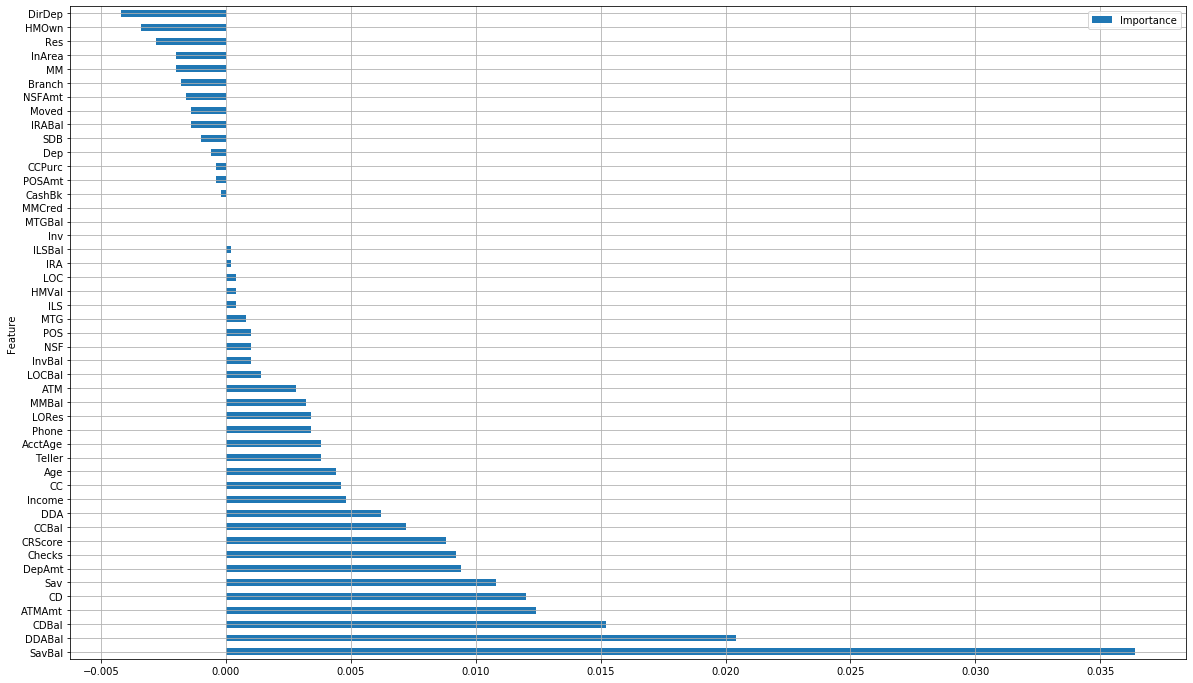

In [45]:
# plt.figure(figsize=(20,8))
imp.plot.barh()
plt.grid()

In [46]:
display_all(train.drop(['Ins'],axis=1).head(10))

,AcctAge,DDA,DDABal,CashBk,Checks,DirDep,NSF,NSFAmt,Phone,Teller,Sav,SavBal,ATM,ATMAmt,POS,POSAmt,CD,CDBal,IRA,IRABal,LOC,LOCBal,ILS,ILSBal,MM,MMBal,MMCred,MTG,MTGBal,CC,CCBal,CCPurc,SDB,Income,HMOwn,LORes,HMVal,Age,CRScore,Moved,InArea,Branch,Res,Dep,DepAmt,Inv,InvBal
0,0.3,1.0,419.27,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,10233.72,1.0,106.74,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1,483.65,0,0.0,16.0,1,11.0,89.0,63.0,696.0,0.0,1.0,8,0,2.0,1170.06,0,0.0
1,0.7,1.0,1986.81,0.0,1.0,1.0,0.0,0.00,0.0,0.0,0.0,0.00,1.0,268.88,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1,0.00,1,0.0,4.0,1,7.0,87.0,51.0,674.0,0.0,1.0,11,0,1.0,446.93,0,0.0
2,4.1,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1,0.00,0,0.0,30.0,1,8.5,97.0,60.0,640.0,0.0,1.0,12,1,0.0,0.00,0,0.0
3,0.5,1.0,1594.84,0.0,1.0,0.0,0.0,0.00,0.0,1.0,1.0,425.06,1.0,278.07,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1,65.76,0,0.0,125.0,1,7.5,145.0,44.0,672.0,0.0,1.0,0,1,1.0,1144.24,0,0.0
4,6.7,1.0,2813.45,0.0,2.0,0.0,0.0,0.00,0.0,5.0,1.0,2716.55,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0.00,0,0.0,25.0,1,6.0,101.0,46.0,648.0,0.0,1.0,0,1,2.0,1208.94,0,0.0
5,12.3,1.0,1069.78,0.0,13.0,1.0,0.0,0.00,2.0,9.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1,38.62,0,0.0,19.0,0,3.0,107.0,55.0,662.0,0.0,1.0,16,2,5.0,6813.58,0,0.0
6,8.8,1.0,1437.57,0.0,12.0,1.0,0.0,0.00,0.0,0.0,0.0,0.00,1.0,391.63,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,94539.95,1,85202.99,0,0.0,55.0,1,3.5,128.0,57.0,659.0,0.0,1.0,0,2,2.0,2237.69,0,0.0
7,9.3,1.0,1683.28,0.0,2.0,1.0,0.0,0.00,0.0,0.0,1.0,967.04,1.0,276.12,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1,0.00,0,0.0,13.0,0,4.5,99.0,58.0,675.0,0.0,1.0,14,2,3.0,795.85,0,0.0
8,0.8,1.0,190.03,0.0,1.0,0.0,1.0,5.65,0.0,0.0,1.0,11.47,1.0,1582.34,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0.00,0,1.0,20.0,0,4.0,107.0,40.0,642.0,0.0,1.0,5,1,3.0,880.25,0,0.0
9,0.9,1.0,462.12,0.0,4.0,0.0,0.0,0.00,0.0,2.0,1.0,9010.40,1.0,863.11,1.0,23.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0.00,0,1.0,54.0,0,4.0,129.0,73.0,667.0,0.0,1.0,15,1,2.0,1049.57,0,0.0


In [47]:
dependence=rf.feature_dependence_matrix(X_train=train.drop(['Ins'],axis=1),)

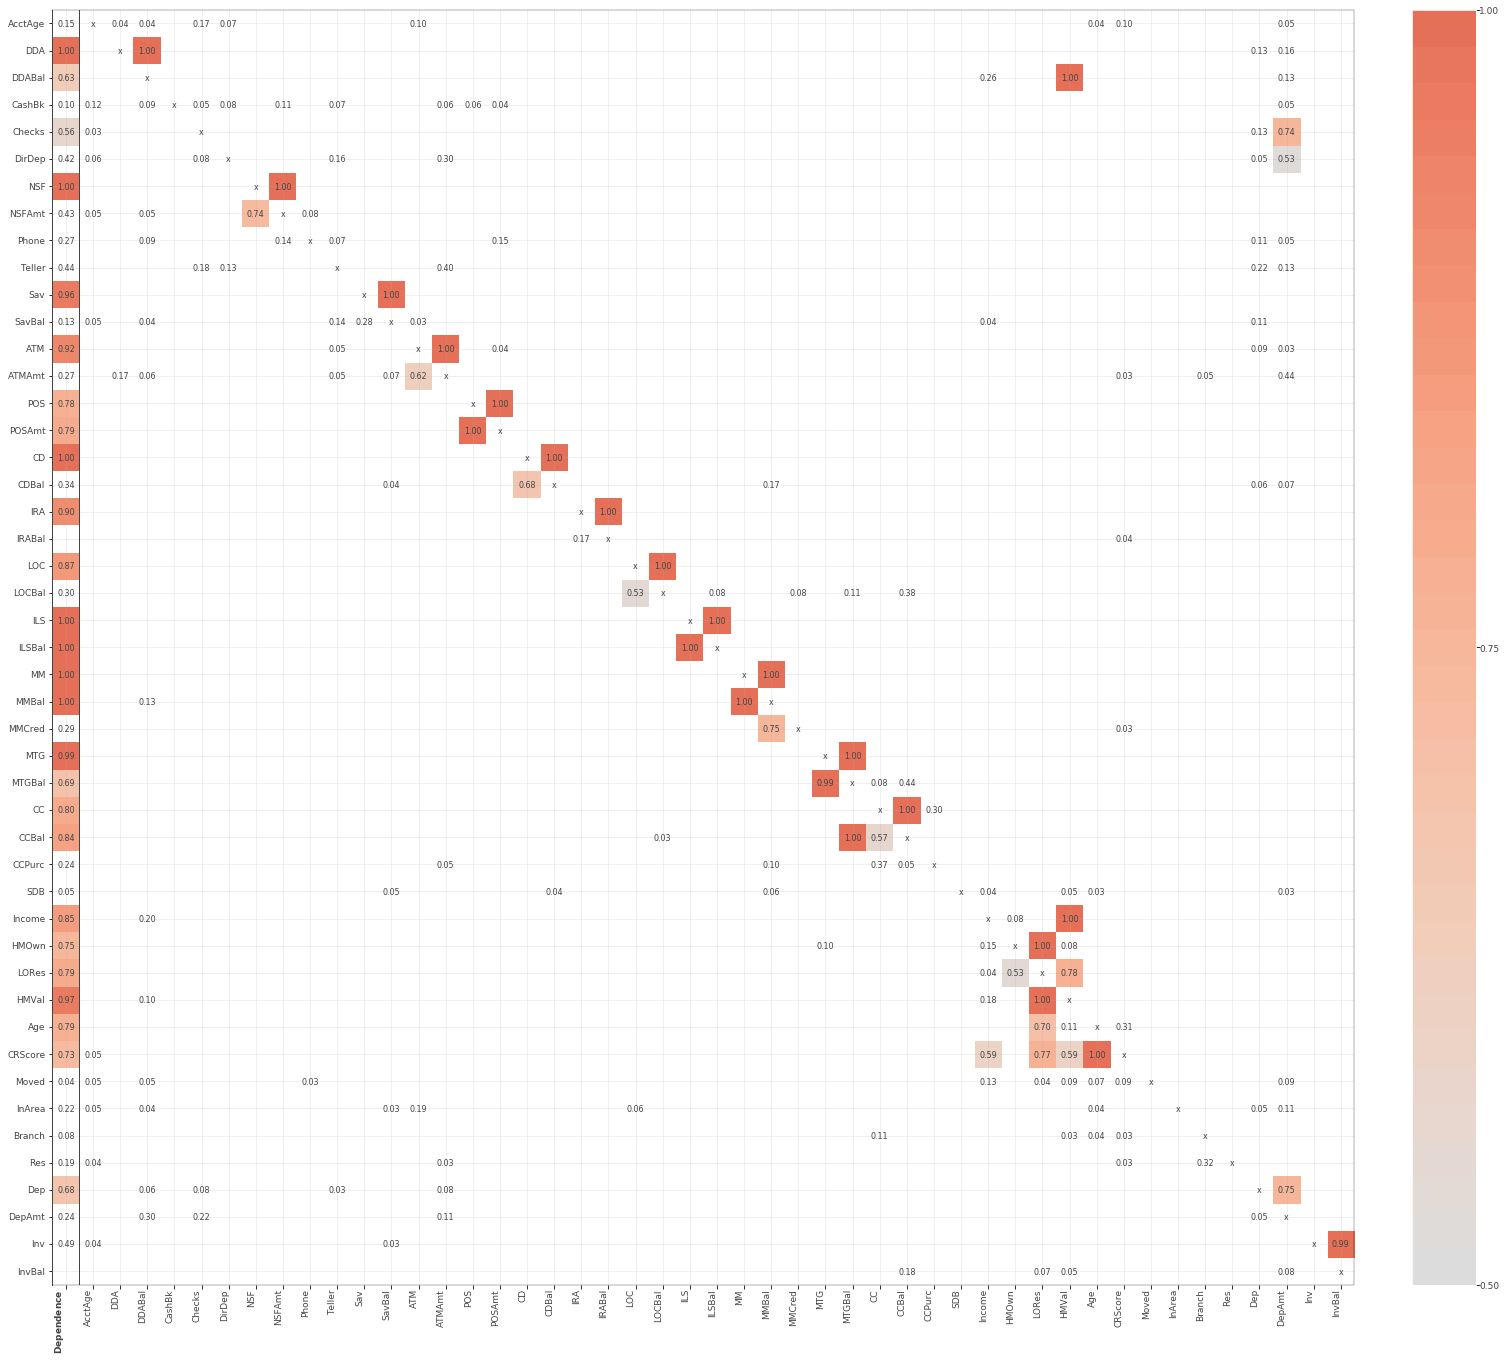

In [48]:
viz=rf.plot_dependence_heatmap(dependence,figsize=(21,19),xrot=90,color_threshold=.5)
viz.save('dependence.svg')

In [66]:
dropcol_imp=rf.dropcol_importances(m,X_train=train.drop(['Ins'],axis=1),
                       y_train=train[['Ins']])

C:\Users\HP\AppData\Local\conda\conda\envs\fastai\lib\site-packages\rfpimp.py:317: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_.fit(X_train, y_train)
C:\Users\HP\AppData\Local\conda\conda\envs\fastai\lib\site-packages\rfpimp.py:326: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_.fit(X_train.drop(col,axis=1), y_train)
C:\Users\HP\AppData\Local\conda\conda\envs\fastai\lib\site-packages\rfpimp.py:326: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_.fit(X_train.drop(col,axis=1), y_train)
C:\Users\HP\AppData\Local\conda\conda\envs\fastai\lib\site-packages\rfpimp.py:326: DataConversionWarning: A column-vector y was passed when a 1d array was expe

C:\Users\HP\AppData\Local\conda\conda\envs\fastai\lib\site-packages\rfpimp.py:326: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_.fit(X_train.drop(col,axis=1), y_train)
C:\Users\HP\AppData\Local\conda\conda\envs\fastai\lib\site-packages\rfpimp.py:326: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_.fit(X_train.drop(col,axis=1), y_train)
C:\Users\HP\AppData\Local\conda\conda\envs\fastai\lib\site-packages\rfpimp.py:326: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_.fit(X_train.drop(col,axis=1), y_train)
C:\Users\HP\AppData\Local\conda\conda\envs\fastai\lib\site-packages\rfpimp.py:326: DataConversionWarning: A column-vector y was passed when a 

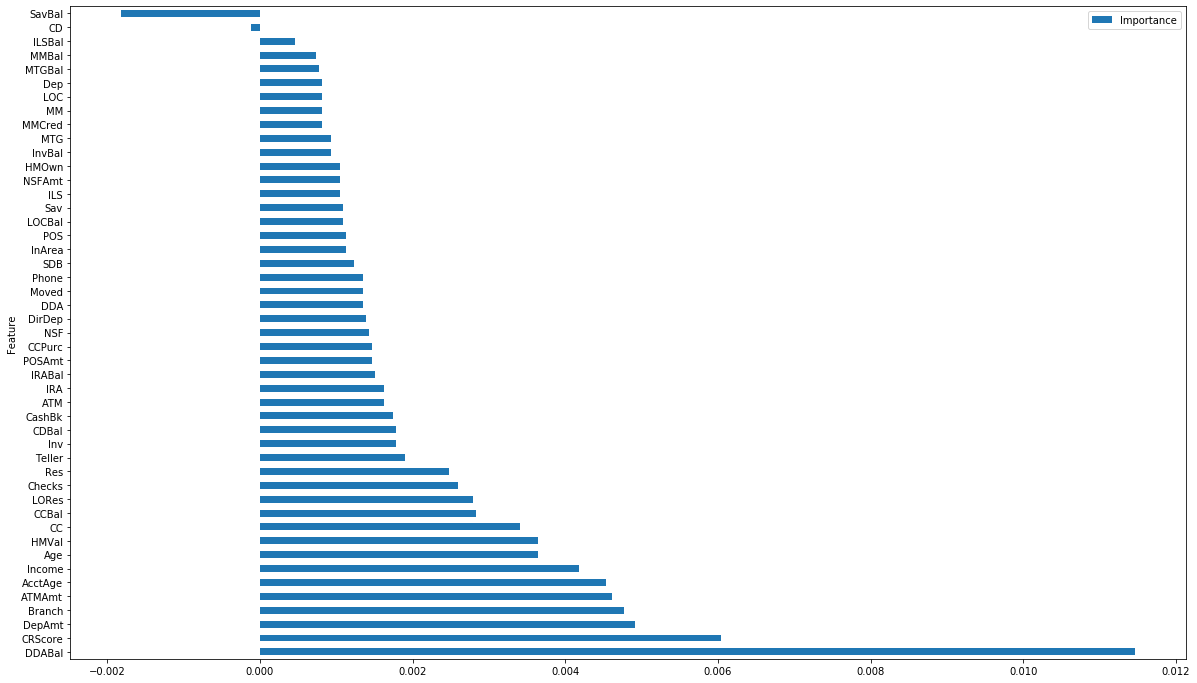

In [67]:
dropcol_imp.plot.barh()

In [68]:
list(dropcol_imp[dropcol_imp.Importance>0].index)

['DDABal',
 'CRScore',
 'DepAmt',
 'Branch',
 'ATMAmt',
 'AcctAge',
 'Income',
 'Age',
 'HMVal',
 'CC',
 'CCBal',
 'LORes',
 'Checks',
 'Res',
 'Teller',
 'Inv',
 'CDBal',
 'CashBk',
 'ATM',
 'IRA',
 'IRABal',
 'POSAmt',
 'CCPurc',
 'NSF',
 'DirDep',
 'DDA',
 'Moved',
 'Phone',
 'SDB',
 'InArea',
 'POS',
 'LOCBal',
 'Sav',
 'ILS',
 'NSFAmt',
 'HMOwn',
 'InvBal',
 'MTG',
 'MMCred',
 'MM',
 'LOC',
 'Dep',
 'MTGBal',
 'MMBal',
 'ILSBal']

In [52]:
space={
    'n_estimators':hp.choice('n_estimators',range(1,700)),
    'criterion':hp.choice('criterion',["gini","entropy"]),
    'max_depth':hp.choice('max_depth',range(1,30)),
    'max_features':hp.uniform('max_features',0,1),
    'min_samples_leaf':hp.uniform('min_samples_leaf',0,0.5)
}

In [53]:
def objective(space):
    m=RandomForestClassifier(n_estimators=space['n_estimators'],
                            criterion=space['criterion'],
                            max_depth=space['max_depth'],
                            max_features=space['max_features'],
                            min_samples_leaf=space['min_samples_leaf'],
                            n_jobs=-1)
    m.fit(train.drop(['Ins'],axis=1),train[['Ins']].values.ravel())
    loss=roc_auc_score(y_score=m.predict(test.drop(['Ins'],axis=1)),y_true=test['Ins'])
    return {'loss':-loss,'status':STATUS_OK}

In [56]:
trials=Trials()
best=fmin(fn=objective,
         space=space,
         algo=tpe.suggest,
         max_evals=100,
         trials=trials,)

100%|████████████████████████████████████████████████| 100/100 [07:31<00:00,  2.96s/it, best loss: -0.7013283896849463]


In [57]:
print(best)

{'criterion': 1, 'max_depth': 25, 'max_features': 0.629539332941629, 'min_samples_leaf': 0.0003439241553194914, 'n_estimators': 345}


In [59]:
best['criterion']='entropy'

In [58]:
best['oob_score']=True

In [60]:
m=RandomForestClassifier(**best)

In [61]:
m.fit(train.drop(['Ins'],axis=1),train[['Ins']].values.ravel())
loss=roc_auc_score(y_score=m.predict(test.drop(['Ins'],axis=1)),y_true=test['Ins'])

In [62]:
m.oob_score_

0.7491767076052845

In [63]:
m.score(test.drop(['Ins'],axis=1),test['Ins'])

0.7449248411591508

In [64]:
roc_auc_score(y_score=m.predict(train.drop(['Ins'],axis=1)),y_true=train['Ins'])

0.8503760530169222

In [65]:
loss

0.6986972517632777

m=RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 15, 'max_features': 0.7322488151003299, 'min_samples_leaf': 0.001779418281509083, 'n_estimators': 286,'oob_score':True})

m.fit(train.drop(['Ins'],axis=1),train[['Ins']].values.ravel())
loss=roc_auc_score(y_score=m.predict(test.drop(['Ins'],axis=1)),y_true=test['Ins'])

m.oob_score_

m.score(test.drop(['Ins'],axis=1),test['Ins'])

roc_auc_score(y_score=m.predict(train.drop(['Ins'],axis=1)),y_true=train['Ins'])

loss

In [69]:
imp=rf.importances(m,test.drop(['Ins'],axis=1),test[['Ins']])

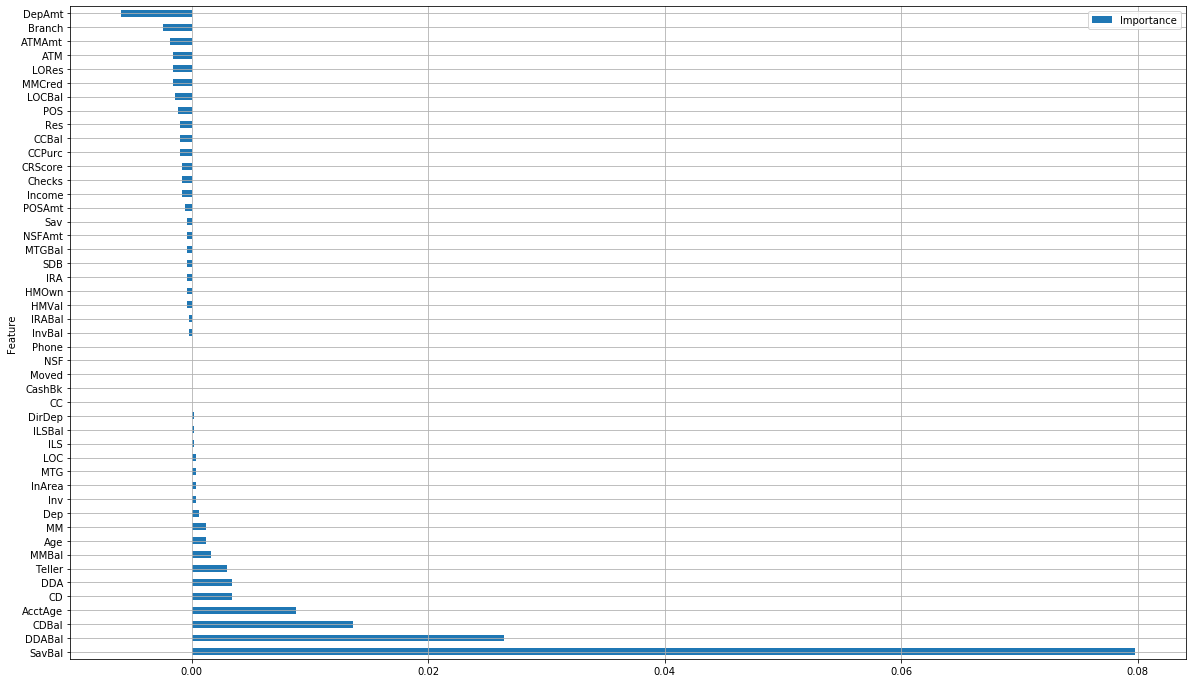

In [70]:
# plt.figure(figsize=(20,8))
imp.plot.barh()
plt.grid()

In [71]:
from scipy.cluster import hierarchy as hc

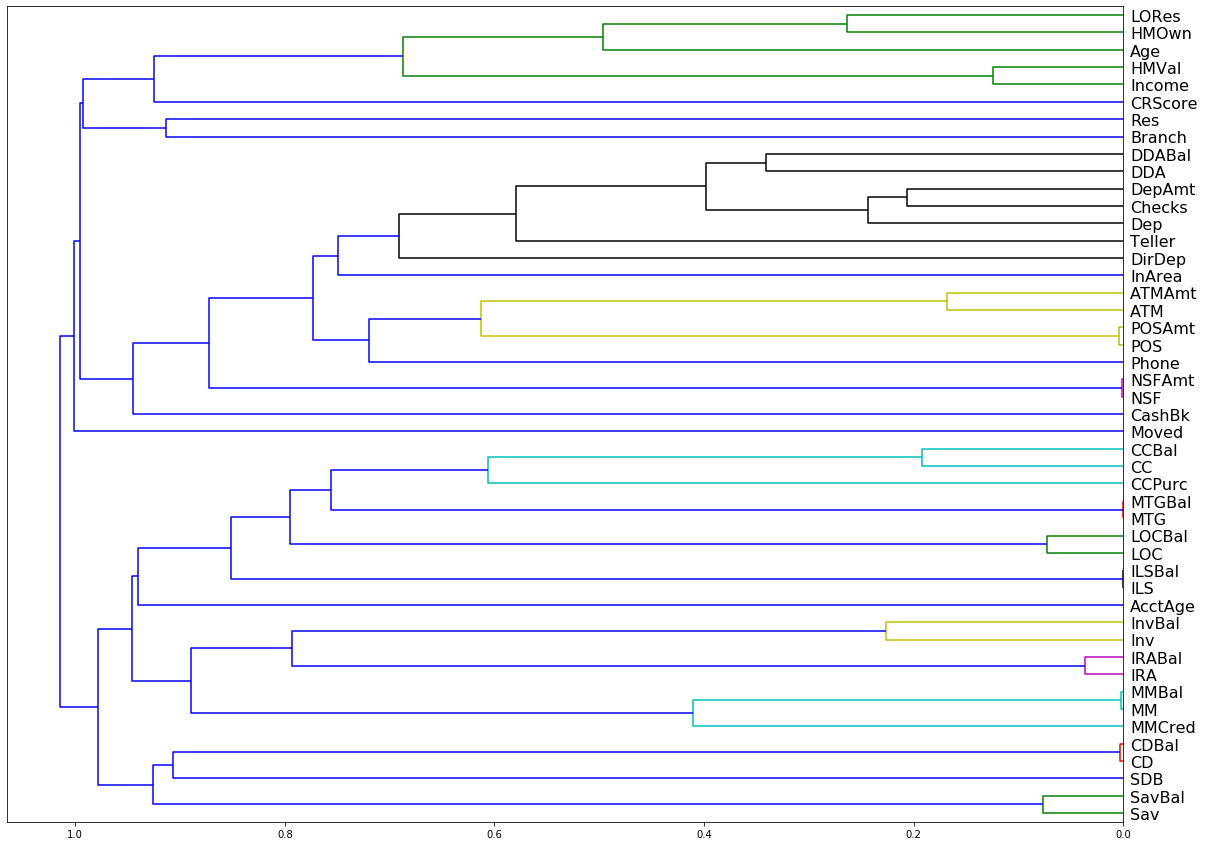

In [72]:
corr = np.round(scipy.stats.spearmanr(test.drop('Ins',axis=1)).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(20,15))
dendrogram = hc.dendrogram(z, labels=test.drop('Ins',axis=1).columns, orientation='left', leaf_font_size=16)
plt.show()

In [73]:
to_drop_cols=['LORes','HMOwn','HMVal','Income','DDABal','DDA','DepAmt','Checks','ATMAmt','ATM','POSAmt','POS',"NSFAmt",'NSF',\
'CCBal','CC','MTGBal','MTG','LOCBal','LOC','ILSBal','ILS','InvBal','Inv','IRABal','IRA','MMBal','MM','CDBal','CD','SavBal','Sav']

In [85]:
print("sdfdsf \t dsfs")

sdfdsf 	 dsfs


In [86]:
def get_oob(df):
    m=RandomForestClassifier(**best)
    X_train, X_test, y_train, y_test = train_test_split(df.drop('Ins',axis=1), df[['Ins']], test_size=0.33, random_state=42)
    m.fit(X_train,y_train.values.ravel())
    loss=roc_auc_score(y_test,m.predict(X_test))
    return (f'oob_score : {m.oob_score_} \t roc : {loss}')

In [87]:
for c in to_drop_cols:
    print(c,get_oob(df_cleaned.drop(c,axis=1)))

LORes oob_score : 0.7495836417468542 	 roc : 0.708598417762987
HMOwn oob_score : 0.7480569948186528 	 roc : 0.7078151538959301


KeyboardInterrupt: 

In [324]:
to_drop=['CD','IRABal','ILS','MTG','Income','ATM','POSAmt','NSFAmt','CCBal','LOC','DDA','Sav','DepAmt']

In [321]:
get_oob(df_cleaned.drop(to_drop,axis=1)) #NO DDA

oob_score : 0.7495836417468542
 roc : 0.7081642897215579


In [323]:
get_oob(df_cleaned.drop(to_drop,axis=1))

oob_score : 0.7503700962250185
 roc : 0.7086989841654714


In [325]:
get_oob(df_cleaned.drop(to_drop,axis=1)) #NO LORes

oob_score : 0.7512490747594375
 roc : 0.7055778553978258


In [75]:
get_oob(df_cleaned)

'oob_score : 0.7506014063656551\t roc : 0.7044761602045371'

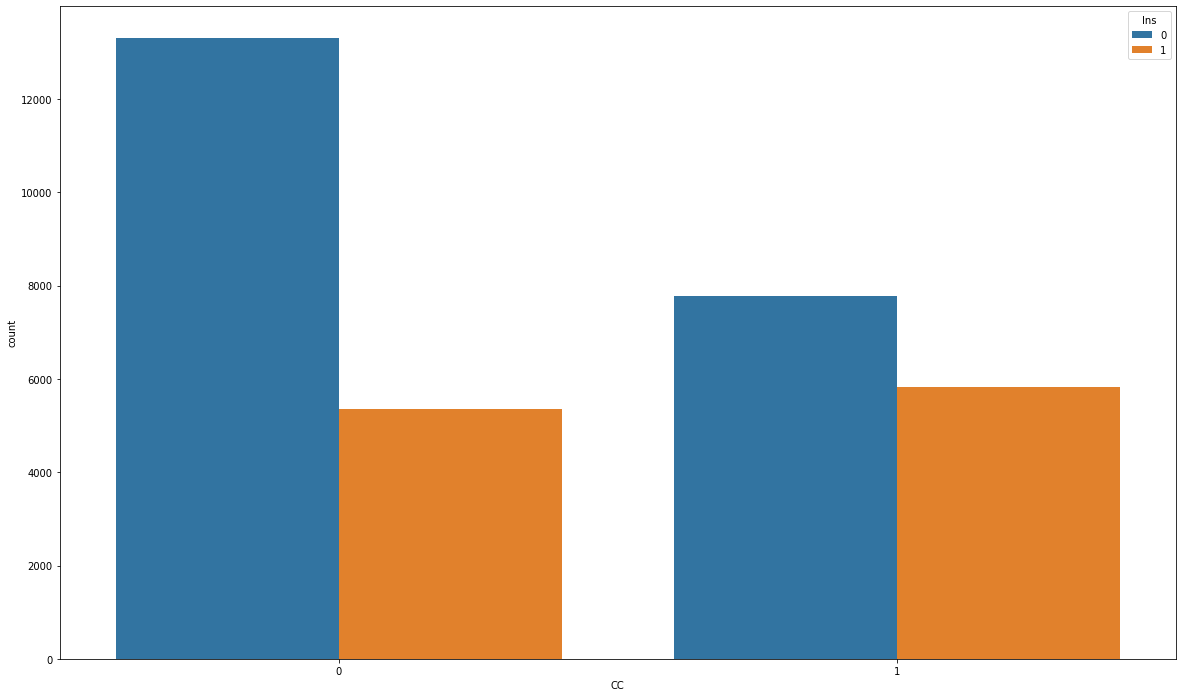

In [328]:
sns.countplot(df_cleaned.CC,hue=df_cleaned.Ins)

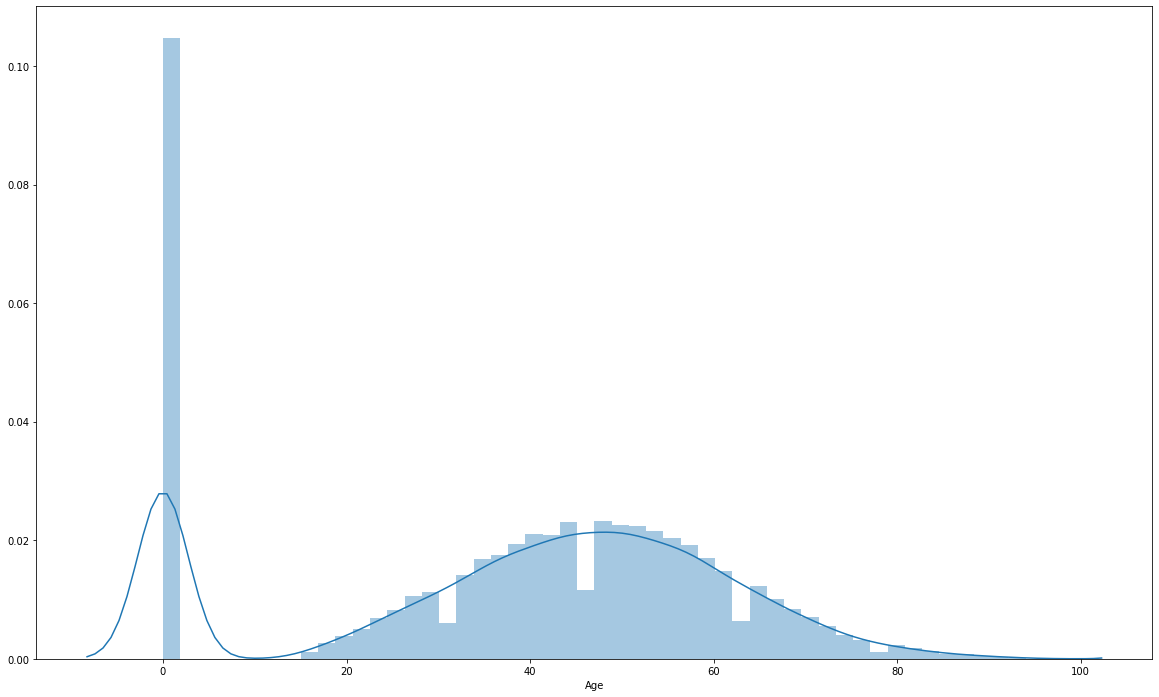

In [336]:
sns.distplot(df_cleaned.Age)

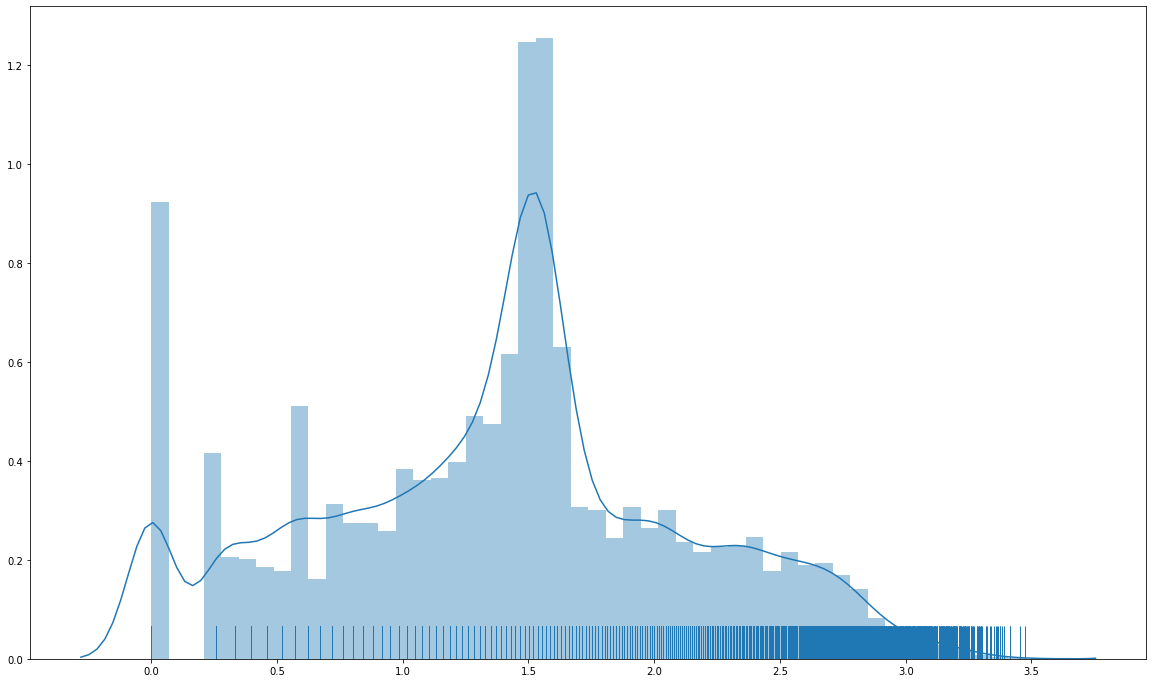

In [335]:
sns.distplot(boxcox(df_cleaned.AcctAge+1)[0],rug=True)

In [337]:
from sklearn.linear_model import LogisticRegressionCV

In [348]:
log=LogisticRegressionCV(Cs=100,max_iter=9000)

m.fit(train.drop(['Ins'],axis=1),train[['Ins']].values.ravel())
loss=roc_auc_score(y_score=m.predict(test.drop(['Ins'],axis=1)),y_true=test['Ins'])

In [350]:
roc_auc_score(y_score=log.predict(test.drop(['Ins'],axis=1)),y_true=test['Ins'])

0.6103013019991126

In [349]:
log.fit(train.drop(['Ins'],axis=1),train[['Ins']].values.ravel())

C:\Users\HP\AppData\Local\conda\conda\envs\fastai\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=100, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=9000, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

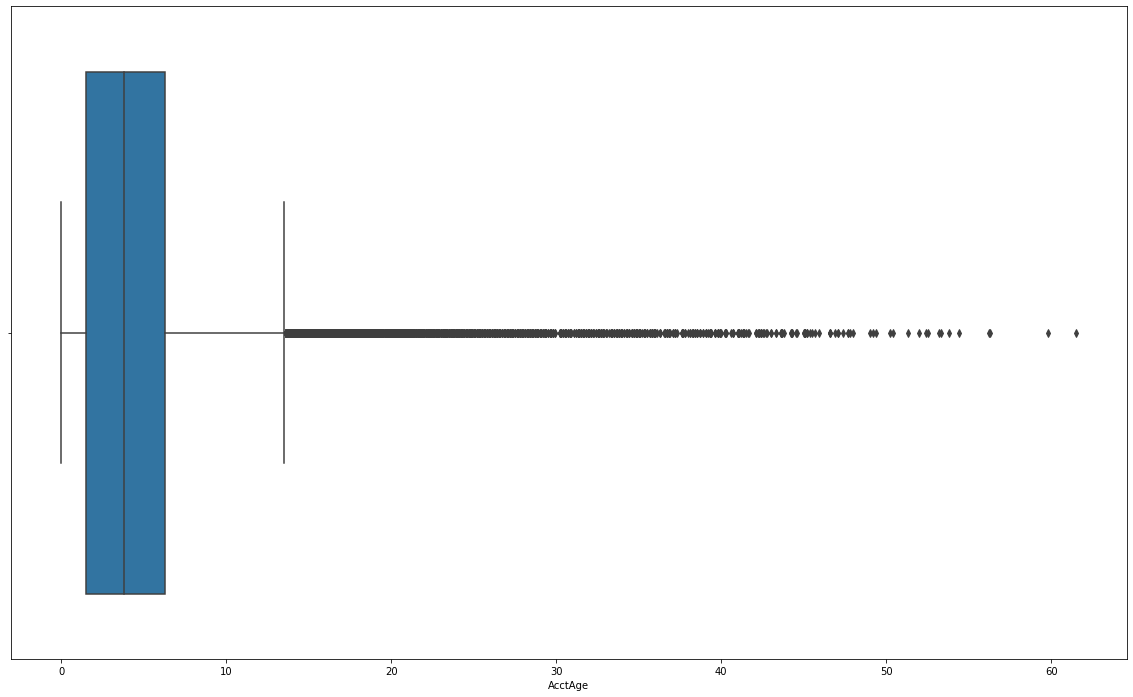

In [353]:
sns.boxplot(df_cleaned.AcctAge)

In [354]:
clf  = XGBClassifier(max_depth = 10,random_state = 10, n_estimators=220, eval_metric = 'auc', min_child_weight = 3,
                    colsample_bytree = 0.75, subsample= 0.9)

In [356]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop('Ins',axis=1), df_cleaned[['Ins']], test_size=0.33, random_state=42)
clf.fit(X_train,y_train.values.ravel())
loss=roc_auc_score(y_test,clf.predict(X_test))

C:\Users\HP\AppData\Local\conda\conda\envs\fastai\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HP\AppData\Local\conda\conda\envs\fastai\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [357]:
loss

0.698571111794291